<a href="https://colab.research.google.com/github/HilkarSoberanes/MachineLearning/blob/main/MNIST_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size=4 color='cornflowerblue'>

# Autoencoder Implementation using the dataset MINIST



The MNIST dataset is comprised of 70000 28 pixels by 28 pixels images of handwritten digits and 70000 vectors containing information on which digit each one is.

## Importing Necessary Modules/Packages 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model

## Loading MNIST Data

In [2]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

11501568/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)


The image training data is scaled from [0, 255] to [0,1] to allow for use of the sigmoid activation function.

## Basic Autoencoder

We define an autoencoder with two Dense layers: an `encoder`, which compresses the images into a 64 dimensional latent vector, and a `decoder`, that reconstructs the original image from the latent space.

In [3]:
latent_dim = 64 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
  
autoencoder = Autoencoder(latent_dim) 

In [4]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

Train the model using `x_train` as both the input and the target. The `encoder` will learn to compress the dataset from 784 dimensions to the latent space, and the `decoder` will learn to reconstruct the original images.

In [5]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 12s 4ms/step - loss: 0.0243 - val_loss: 0.0093
Epoch 2/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0071 - val_loss: 0.0054
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0051 - val_loss: 0.0046
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0046 - val_loss: 0.0043
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0044 - val_loss: 0.0042
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.00

Now that the model is trained, let's test it by encoding and decoding images from the test set.

In [6]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

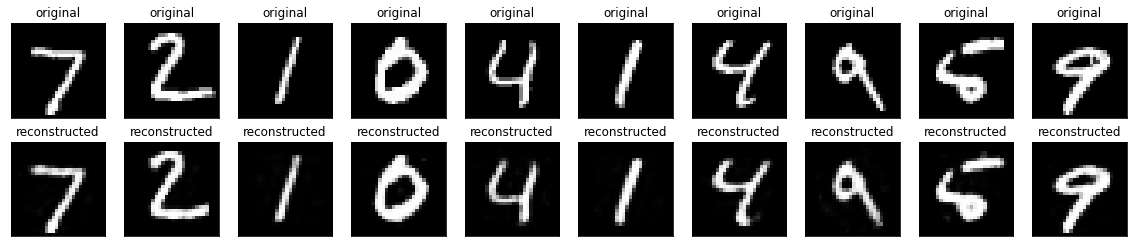

In [7]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

## Image denoising

An autoencoder can also be trained to remove noise from images. We will create a noisy version of the MNIST dataset by applying random noise to each image. And then we will train an autoencoder using the noisy image as input, and the original image as the target.

In [8]:
(x_train, _), (x_test, _) = mnist.load_data()

In [9]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)

(60000, 28, 28, 1)


Adding random noise to the images

In [10]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

Plot the noisy images

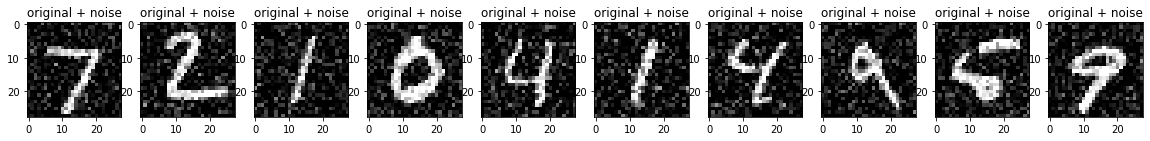

In [11]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

### Convolutional Autoencoder

We define an encoder with convolutional layers and a decoder with convolutiional transposed layers 

In [12]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [13]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [14]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
1875/1875 [==============================] - 19s 5ms/step - loss: 0.0136 - val_loss: 0.0038
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 4/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 6/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 8/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 9/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 10/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.00

Let's take a look at a summary of the encoder and the decoder.

In [15]:
autoencoder.encoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


In [16]:
autoencoder.decoder.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTra  (None, 14, 14, 8)        584       
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 16)       1168      
 ranspose)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         145       
                                                                 
Total params: 1,897
Trainable params: 1,897
Non-trainable params: 0
_________________________________________________________________


In [17]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

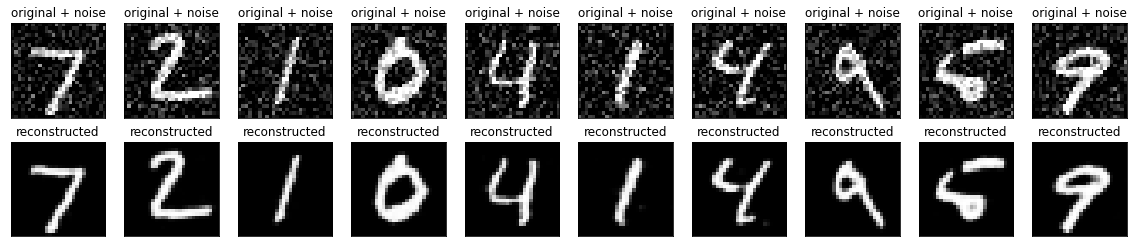

In [18]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()